In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from copy import deepcopy

from nflows.utils import tensor2numpy, create_mid_split_binary_mask
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, 
    InverseTransform,
    BatchNorm,
    PointwiseAffineTransform,
    Tanh,
    ReversePermutation,
    MaskedAffineAutoregressiveTransform as MAF,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform as RQ_NSF_AR,
    PiecewiseRationalQuadraticCouplingTransform as RQ_NSF_C,
    )
from nflows.nn.nets import ResidualNet
from nflows.flows.base import Flow

device = torch.device('cpu')

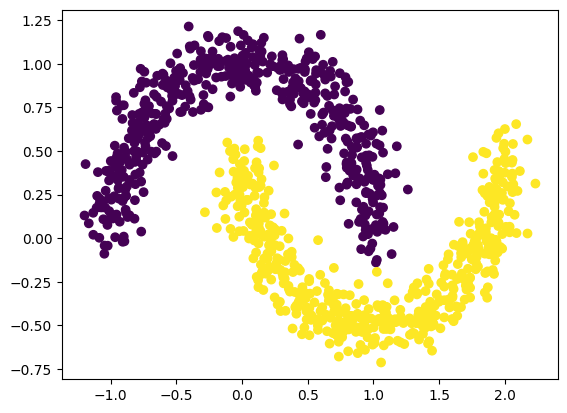

In [2]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

## RQ-NSF-C

In [3]:
num_layers = 5
hidden_features = 100
num_blocks = 2
activation = torch.relu
num_bins = 5
tails = 'linear'
tail_bound = 5.

base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(RQ_NSF_C(
        mask=create_mid_split_binary_mask(2),
        transform_net_create_fn=lambda in_features, out_features: ResidualNet(
            in_features,
            out_features,
            hidden_features=hidden_features,
            context_features=1,
            num_blocks=num_blocks,
            activation=activation,
            dropout_probability=0.,
            use_batch_norm=False,
            ),
        num_bins=num_bins,
        tails=tails,
        tail_bound=tail_bound,
        # apply_unconditional_transform=False,
        # img_shape=None,
        # min_bin_width=splines.rational_quadratic.DEFAULT_MIN_BIN_WIDTH,
        # min_bin_height=splines.rational_quadratic.DEFAULT_MIN_BIN_HEIGHT,
        # min_derivative=splines.rational_quadratic.DEFAULT_MIN_DERIVATIVE,
        ))
    transforms.append(ReversePermutation(features=2))
    # transforms.append(BatchNorm())
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [10]:
epochs = 1000
batch_size = 128
lr = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
best_epoch = 0
best_loss = np.inf

for epoch in range(epochs):    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)
    y = torch.tensor(y[:, None], dtype=torch.float32).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_flow = deepcopy(flow)
        
    print(epoch, float(loss))

0 2.645533800125122
1 2.4767982959747314
2 2.2994256019592285
3 2.1844470500946045
4 2.1081340312957764
5 2.0848658084869385
6 2.002237319946289
7 1.9024641513824463
8 1.8223533630371094
9 1.7216100692749023
10 1.6592588424682617
11 1.5073703527450562
12 1.4192379713058472
13 1.3128466606140137
14 1.2941079139709473
15 1.2648811340332031
16 1.2490617036819458
17 1.1581382751464844
18 1.0559942722320557
19 1.0424480438232422
20 1.0053679943084717
21 1.0170001983642578
22 0.9905797243118286
23 0.9292696118354797
24 0.9267622828483582
25 0.7920032739639282
26 0.9024102091789246
27 0.8030077219009399
28 0.6939334273338318
29 0.7484570145606995
30 0.6656688451766968
31 0.7497808933258057
32 0.6702452898025513
33 0.6101430058479309
34 0.6390858888626099
35 0.6442203521728516
36 0.6043099761009216
37 0.584082305431366
38 0.6430763602256775
39 0.5963974595069885
40 0.5924948453903198
41 0.6807423830032349
42 0.5892425179481506
43 0.6745848655700684
44 0.4753800630569458
45 0.7817790508270264
4

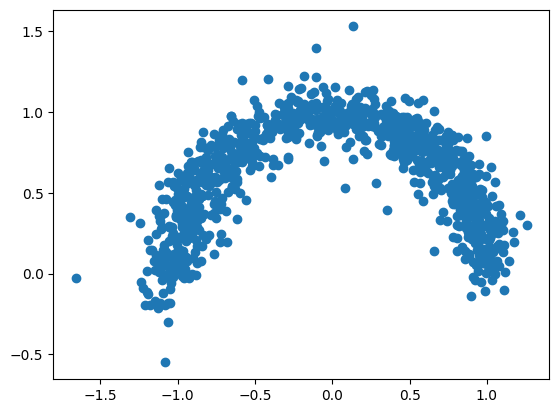

In [19]:
plt.scatter(
    *best_flow.sample(
        1_000, torch.tensor([[0.]]),
        )[0].detach().numpy().T,
    );

In [33]:
zgrid = torch.zeros(xy.shape[0])
zgrid.shape

torch.Size([40000])

In [ ]:
p = 3
n = 200

x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],
    axis=1,
    dtype=np.float32,
    )

with torch.no_grad():
    zgrid = torch.zeros(xy.shape[0])
    for context in [0., 1.]:
        zgrid += best_flow.log_prob(
            torch.tensor(xy), torch.tensor([[context]]*xy.shape[0]),
            ).exp()#.reshape(n, n)
        
plt.imshow(
    zgrid.numpy().reshape(n, n),
    origin='lower',
    aspect='equal',
    extent=(-p, p, -p, p),
    );